CRIANDOS PERSONAS

In [ ]:
# 1️ Importar bibliotecas
import pandas as pd
import numpy as np

# 2️ Carregar datasets do Olist
# Ajuste o caminho do arquivo CSV para onde você baixou
pd.read_csv("downloads/olist_customers_dataset.csv")
orders = pd.read_csv("downloads/olist_orders_dataset.csv")
order_items = pd.read_csv("downloads/olist_order_items_dataset.csv")
products = pd.read_csv("downloads/olist_products_dataset.csv")
reviews = pd.read_csv("downloads/olist_order_reviews_dataset.csv")

In [ ]:
# 3️ Limpeza básica
# Filtrar apenas pedidos entregues
orders = orders[orders['order_status'] == 'delivered']

# Converter datas
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Unir datasets para ter informações completas
df = orders.merge(order_items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(customers, on='customer_id', how='left') \
           .merge(reviews[['order_id','review_score']], on='order_id', how='left')


In [ ]:
# 4️ Criar métricas RFM
# Recência (dias desde a última compra)
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

In [ ]:
# 5️ Segmentar clientes com base em RFM (simplificado)
# Top 20% frequência + monetário = Cliente premium
rfm['Segment'] = 'Occasional'
rfm.loc[(rfm['Frequency'] >= rfm['Frequency'].quantile(0.8)) & 
        (rfm['Monetary'] >= rfm['Monetary'].quantile(0.8)), 'Segment'] = 'High Value'
rfm.loc[(rfm['Recency'] <= rfm['Recency'].quantile(0.2)) & (rfm['Segment'] == 'Occasional'), 'Segment'] = 'Recent Buyer'


In [ ]:
# 6️ Criar personas baseadas em segmentos
# Função para extrair informações resumidas de cada persona
def create_persona(segment_name):
    subset = df[df['customer_id'].isin(rfm[rfm['Segment']==segment_name]['customer_id'])]
    
    persona = {}
    persona['Nome'] = segment_name
    persona['Idade/Profissão (estimativa)'] = "Adulto(a), profissional ativo"
    persona['Localização'] = subset['customer_state'].mode()[0]
    persona['Ticket Médio'] = round(subset.groupby('customer_id')['price'].sum().mean(),2)
    persona['Frequência de Compra'] = round(subset.groupby('customer_id')['order_id'].nunique().mean(),1)
    persona['Categorias Preferidas'] = subset['product_category_name'].value_counts().head(3).index.tolist()
    
    # Dores / objetivos (exemplo baseado no segmento)
    if segment_name == 'High Value':
        persona['Objetivo'] = 'Eficiência e conveniência, produtos de qualidade'
        persona['Dores'] = 'Atrasos na entrega ou falta de estoque'
        persona['Canais Preferidos'] = 'App mobile e e-mail'
    elif segment_name == 'Recent Buyer':
        persona['Objetivo'] = 'Testar produtos e avaliar serviços'
        persona['Dores'] = 'Informações insuficientes sobre produtos'
        persona['Canais Preferidos'] = 'Site e notificações'
    else:
        persona['Objetivo'] = 'Comprar quando necessário, custo-benefício'
        persona['Dores'] = 'Complexidade na navegação e tempo de entrega'
        persona['Canais Preferidos'] = 'Site e redes sociais'
    
    return persona

In [ ]:
# 7️ Criar as 3 personas
personas = []
for segment in ['High Value', 'Recent Buyer', 'Occasional']:
    personas.append(create_persona(segment))

In [ ]:
# 8️ Mostrar personas
for p in personas:
    print("\n============================")
    for k,v in p.items():
        print(f"{k}: {v}")



Nome: High Value
Idade/Profissão (estimativa): Adulto(a), profissional ativo
Localização: SP
Ticket Médio: 387.9
Frequência de Compra: 1.0
Categorias Preferidas: ['cama_mesa_banho', 'relogios_presentes', 'beleza_saude']
Objetivo: Eficiência e conveniência, produtos de qualidade
Dores: Atrasos na entrega ou falta de estoque
Canais Preferidos: App mobile e e-mail

Nome: Recent Buyer
Idade/Profissão (estimativa): Adulto(a), profissional ativo
Localização: SP
Ticket Médio: 75.47
Frequência de Compra: 1.0
Categorias Preferidas: ['beleza_saude', 'cama_mesa_banho', 'utilidades_domesticas']
Objetivo: Testar produtos e avaliar serviços
Dores: Informações insuficientes sobre produtos
Canais Preferidos: Site e notificações

Nome: Occasional
Idade/Profissão (estimativa): Adulto(a), profissional ativo
Localização: SP
Ticket Médio: 74.83
Frequência de Compra: 1.0
Categorias Preferidas: ['cama_mesa_banho', 'esporte_lazer', 'beleza_saude']
Objetivo: Comprar quando necessário, custo-benefício
Dores: C

In [ ]:
High Value

Ticket médio: R$387,90 → clientes que gastam mais
Frequência: 1 compra (pode indicar dataset recente ou poucos pedidos por cliente)
Categorias: cama, mesa e banho; relógios e presentes; beleza e saúde
Objetivo: eficiência e conveniência
Dores: atrasos na entrega ou falta de estoque
Canais preferidos: app mobile e e-mail

Recent Buyer

Ticket médio: R$75,47 → clientes novos ou que compram pouco
Categorias: beleza e saúde; cama, mesa e banho; utilidades domésticas
Objetivo: testar produtos
Dores: informações insuficientes sobre produtos
Canais: site e notificações

Occasional

Ticket médio: R$74,83 → clientes que compram esporadicamente
Categorias: cama, mesa e banho; esporte e lazer; beleza e saúde
Objetivo: comprar quando necessário, custo-benefício
Dores: dificuldade na navegação, tempo de entrega
Canais: site e redes sociais

SyntaxError: invalid character '→' (U+2192) (3713227994.py, line 3)

Vamos criar uma visualização gráfica das 3 personas usando Python e Matplotlib. A ideia é mostrar:

Ticket médio
Frequência de compra
Principais categorias compradas

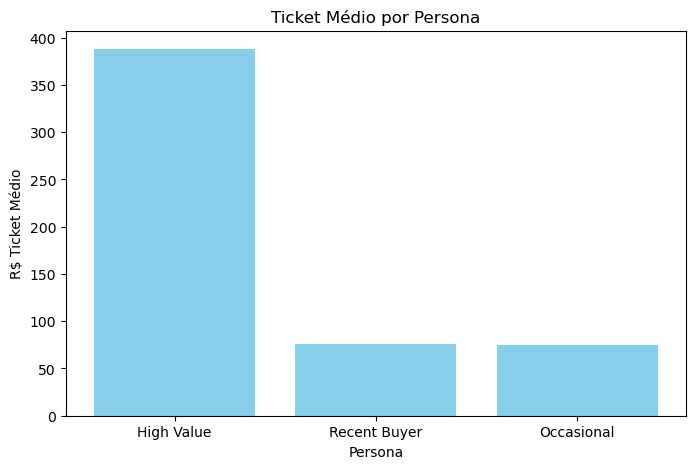

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Transformar personas em DataFrame
df_personas = pd.DataFrame(personas)

# 1️ Gráfico de Ticket Médio
plt.figure(figsize=(8,5))
plt.bar(df_personas['Nome'], df_personas['Ticket Médio'], color='skyblue')
plt.title('Ticket Médio por Persona')
plt.ylabel('R$ Ticket Médio')
plt.xlabel('Persona')
plt.show()

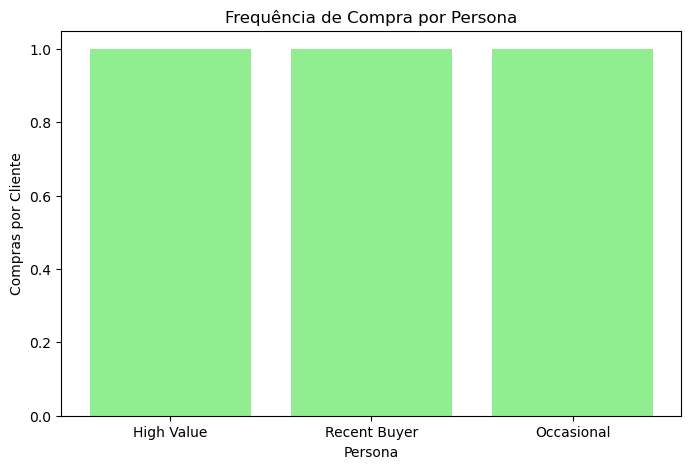

In [ ]:
# 2️ Gráfico de Frequência de Compra
plt.figure(figsize=(8,5))
plt.bar(df_personas['Nome'], df_personas['Frequência de Compra'], color='lightgreen')
plt.title('Frequência de Compra por Persona')
plt.ylabel('Compras por Cliente')
plt.xlabel('Persona')
plt.show()

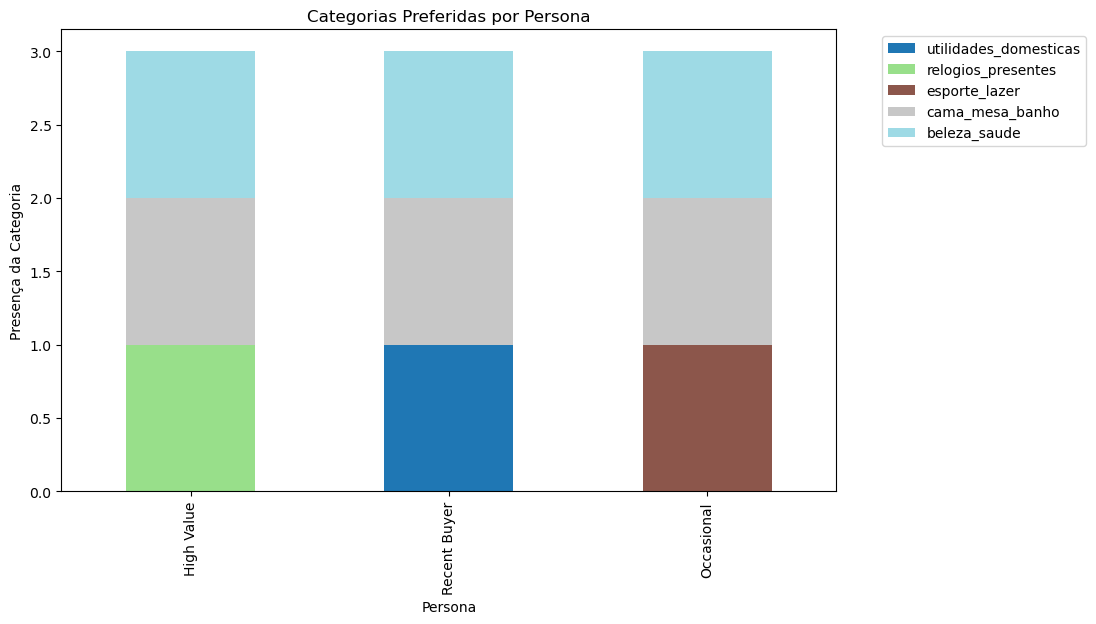

In [ ]:
# Transformar o set em lista
categories = list(set(cat for sublist in df_personas['Categorias Preferidas'] for cat in sublist))

# Criar a matriz inicial
category_matrix = pd.DataFrame(0, index=df_personas['Nome'], columns=categories)

# Preencher a matriz
for i, row in df_personas.iterrows():
    for cat in row['Categorias Preferidas']:
        category_matrix.loc[row['Nome'], cat] = 1

# Plotar gráfico de barras empilhadas
category_matrix.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('Categorias Preferidas por Persona')
plt.ylabel('Presença da Categoria')
plt.xlabel('Persona')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

O que cada gráfico mostra:

Ticket Médio: diferença de gasto entre as personas.

Frequência de Compra: visualiza se a persona é frequente ou ocasional.

Categorias Preferidas: gráfico empilhado mostrando quais categorias cada persona mais compra.

C:\Users\marco\AppData\Local\Temp\ipykernel_13296\3615007054.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nome', y='Ticket Médio', data=df_personas, palette="Blues_d", ax=axes[0,0])
C:\Users\marco\AppData\Local\Temp\ipykernel_13296\3615007054.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nome', y='Frequência de Compra', data=df_personas, palette="Greens_d", ax=axes[0,1])


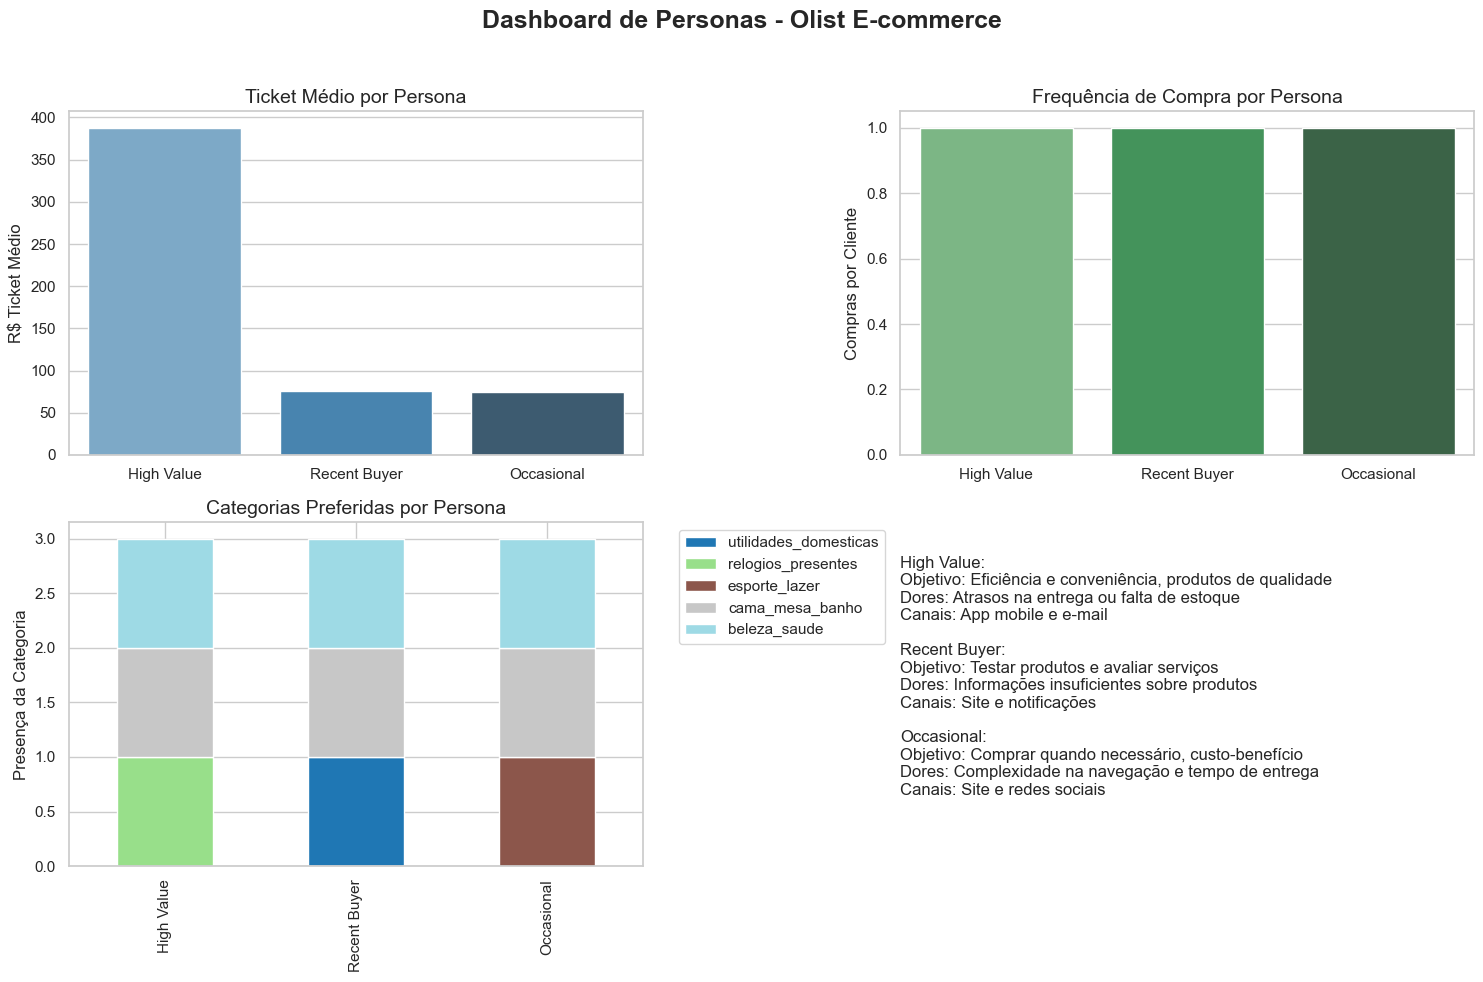

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supondo que df_personas já exista
# df_personas = pd.DataFrame(personas)

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Dashboard de Personas - Olist E-commerce", fontsize=18, weight='bold')

# -------------------------
# 1️⃣ Ticket Médio
sns.barplot(x='Nome', y='Ticket Médio', data=df_personas, palette="Blues_d", ax=axes[0,0])
axes[0,0].set_title("Ticket Médio por Persona", fontsize=14)
axes[0,0].set_ylabel("R$ Ticket Médio")
axes[0,0].set_xlabel("")

# -------------------------
# 2️⃣ Frequência de Compra
sns.barplot(x='Nome', y='Frequência de Compra', data=df_personas, palette="Greens_d", ax=axes[0,1])
axes[0,1].set_title("Frequência de Compra por Persona", fontsize=14)
axes[0,1].set_ylabel("Compras por Cliente")
axes[0,1].set_xlabel("")

# -------------------------
# 3️⃣ Categorias Preferidas (Barras empilhadas)
categories = list(set(cat for sublist in df_personas['Categorias Preferidas'] for cat in sublist))
category_matrix = pd.DataFrame(0, index=df_personas['Nome'], columns=categories)
for i, row in df_personas.iterrows():
    for cat in row['Categorias Preferidas']:
        category_matrix.loc[row['Nome'], cat] = 1

category_matrix.plot(kind='bar', stacked=True, colormap='tab20', ax=axes[1,0])
axes[1,0].set_title("Categorias Preferidas por Persona", fontsize=14)
axes[1,0].set_ylabel("Presença da Categoria")
axes[1,0].set_xlabel("")
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# -------------------------
# 4️⃣ Informações qualitativas resumidas
axes[1,1].axis('off')  # desativar eixo
text = ""
for i, row in df_personas.iterrows():
    text += f"{row['Nome']}:\n"
    text += f"Objetivo: {row['Objetivo']}\n"
    text += f"Dores: {row['Dores']}\n"
    text += f"Canais: {row['Canais Preferidos']}\n\n"
axes[1,1].text(0, 0.5, text, fontsize=12, va='center', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import pandas as pd

# atribuir a persona certa a cada cliente do dataset Olist, incluindo todas as informações da persona:

# 1️ Preparar dados
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 2️ Calcular RFM
rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# 3️ Criar segmentos RFM
rfm['Segment'] = 'Occasional'
rfm.loc[(rfm['Frequency'] >= rfm['Frequency'].quantile(0.8)) &
        (rfm['Monetary'] >= rfm['Monetary'].quantile(0.8)), 'Segment'] = 'High Value'
rfm.loc[(rfm['Recency'] <= rfm['Recency'].quantile(0.2)) &
        (rfm['Segment'] == 'Occasional'), 'Segment'] = 'Recent Buyer'

# 4️ Função para criar persona
def create_persona(segment_name):
    subset = df[df['customer_id'].isin(rfm[rfm['Segment']==segment_name]['customer_id'])]
    
    persona = {}
    persona['Nome'] = segment_name
    persona['Idade/Profissão (estimativa)'] = "Adulto(a), profissional ativo"
    persona['Localização'] = subset['customer_state'].mode()[0]
    persona['Ticket Médio'] = round(subset.groupby('customer_id')['price'].sum().mean(),2)
    persona['Frequência de Compra'] = round(subset.groupby('customer_id')['order_id'].nunique().mean(),1)
    persona['Categorias Preferidas'] = subset['product_category_name'].value_counts().head(3).index.tolist()
    
    if segment_name == 'High Value':
        persona['Objetivo'] = 'Eficiência e conveniência, produtos de qualidade'
        persona['Dores'] = 'Atrasos na entrega ou falta de estoque'
        persona['Canais Preferidos'] = 'App mobile e e-mail'
    elif segment_name == 'Recent Buyer':
        persona['Objetivo'] = 'Testar produtos e avaliar serviços'
        persona['Dores'] = 'Informações insuficientes sobre produtos'
        persona['Canais Preferidos'] = 'Site e notificações'
    else:
        persona['Objetivo'] = 'Comprar quando necessário, custo-benefício'
        persona['Dores'] = 'Complexidade na navegação e tempo de entrega'
        persona['Canais Preferidos'] = 'Site e redes sociais'
    
    return persona

# 5️ Criar lista de personas
personas = []
for segment in ['High Value', 'Recent Buyer', 'Occasional']:
    personas.append(create_persona(segment))

df_personas = pd.DataFrame(personas)

# 6️ Atribuir persona a cada cliente
# Merge com rfm para ter o segmento
rfm_with_persona = rfm.merge(df_personas, left_on='Segment', right_on='Nome', how='left')

# 7️ Visualizar resultado final
result = rfm_with_persona[['customer_id', 'Segment', 'Ticket Médio', 'Frequência de Compra',
                           'Categorias Preferidas', 'Objetivo', 'Dores', 'Canais Preferidos']]

print(result.head())


                        customer_id     Segment  Ticket Médio  \
0  00012a2ce6f8dcda20d059ce98491703  Occasional         74.83   
1  000161a058600d5901f007fab4c27140  Occasional         74.83   
2  0001fd6190edaaf884bcaf3d49edf079  High Value        387.90   
3  0002414f95344307404f0ace7a26f1d5  Occasional         74.83   
4  000379cdec625522490c315e70c7a9fb  Occasional         74.83   

   Frequência de Compra                              Categorias Preferidas  \
0                   1.0     [cama_mesa_banho, esporte_lazer, beleza_saude]   
1                   1.0     [cama_mesa_banho, esporte_lazer, beleza_saude]   
2                   1.0  [cama_mesa_banho, relogios_presentes, beleza_s...   
3                   1.0     [cama_mesa_banho, esporte_lazer, beleza_saude]   
4                   1.0     [cama_mesa_banho, esporte_lazer, beleza_saude]   

                                           Objetivo  \
0        Comprar quando necessário, custo-benefício   
1        Comprar quando necess

O que este código faz:

Calcula RFM para todos os clientes do Olist.

Cria segmentos RFM: High Value, Recent Buyer e Occasional.

Gera personas detalhadas para cada segmento.

Atribui a persona correta a cada cliente usando merge.

Mostra uma tabela final com informações completas da persona para cada cliente.

# Agora vou ciar uma versão visual mostrando cada cliente do Olist com sua persona de forma gráfica, usando cores por segmento e gráficos resumidos de Ticket Médio e Frequência de Compra.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

C:\Users\marco\AppData\Local\Temp\ipykernel_13296\3710263944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm_with_persona, palette='Set2')


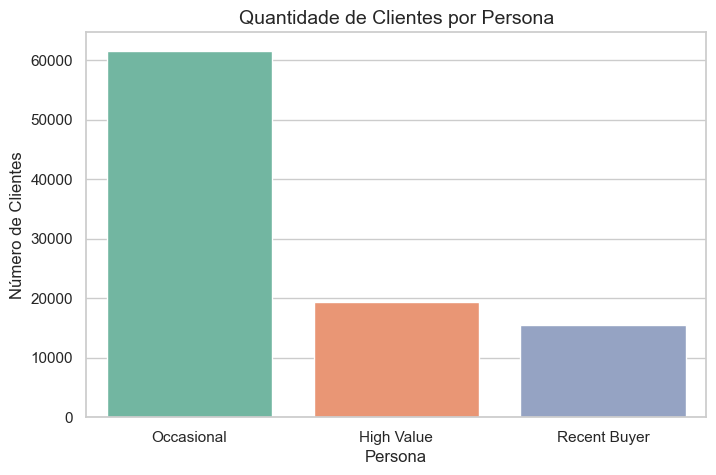

In [ ]:
#  Gráfico de distribuição de clientes por persona
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm_with_persona, palette='Set2')
plt.title('Quantidade de Clientes por Persona', fontsize=14)
plt.ylabel('Número de Clientes')
plt.xlabel('Persona')
plt.show()

C:\Users\marco\AppData\Local\Temp\ipykernel_13296\2926826697.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\marco\AppData\Local\Temp\ipykernel_13296\2926826697.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




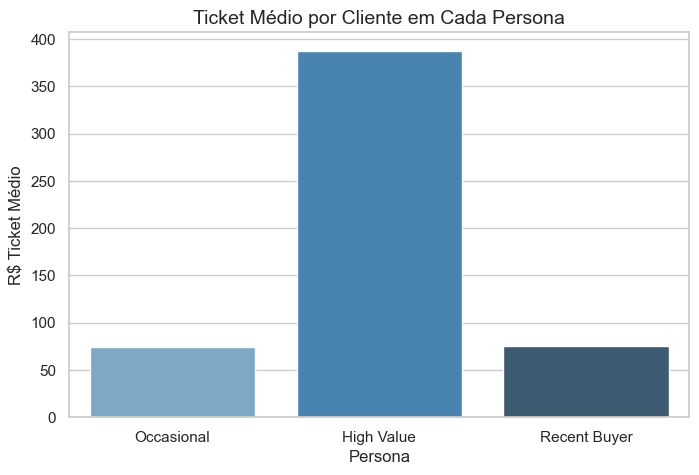

In [ ]:
#  Ticket Médio por persona
plt.figure(figsize=(8,5))
sns.barplot(x='Segment', y='Ticket Médio', data=rfm_with_persona, palette='Blues_d', ci=None)
plt.title('Ticket Médio por Cliente em Cada Persona', fontsize=14)
plt.ylabel('R$ Ticket Médio')
plt.xlabel('Persona')
plt.show()

C:\Users\marco\AppData\Local\Temp\ipykernel_13296\2213628660.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\marco\AppData\Local\Temp\ipykernel_13296\2213628660.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




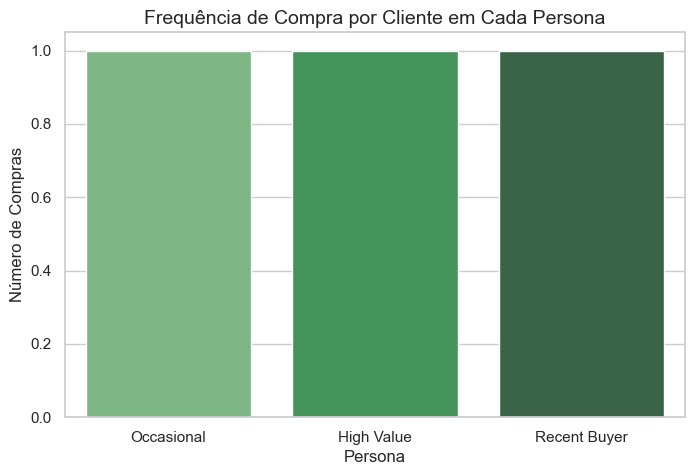

In [ ]:
#  Frequência de Compra por persona
plt.figure(figsize=(8,5))
sns.barplot(x='Segment', y='Frequência de Compra', data=rfm_with_persona, palette='Greens_d', ci=None)
plt.title('Frequência de Compra por Cliente em Cada Persona', fontsize=14)
plt.ylabel('Número de Compras')
plt.xlabel('Persona')
plt.show()

<Figure size 1000x600 with 0 Axes>

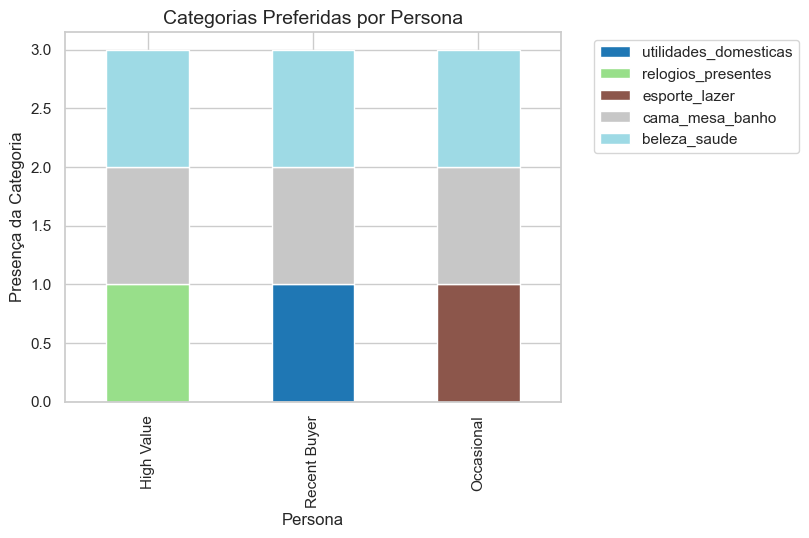

In [ ]:
# Categorias Preferidas por persona (Resumo visual)
# Contar presença de cada categoria por persona
categories = list(set(cat for sublist in df_personas['Categorias Preferidas'] for cat in sublist))
category_matrix = pd.DataFrame(0, index=df_personas['Nome'], columns=categories)
for i, row in df_personas.iterrows():
    for cat in row['Categorias Preferidas']:
        category_matrix.loc[row['Nome'], cat] = 1

plt.figure(figsize=(10,6))
category_matrix.plot(kind='bar', stacked=True, colormap='tab20', legend=False)
plt.title('Categorias Preferidas por Persona', fontsize=14)
plt.ylabel('Presença da Categoria')
plt.xlabel('Persona')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
